In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device: ', device)

Device:  cuda


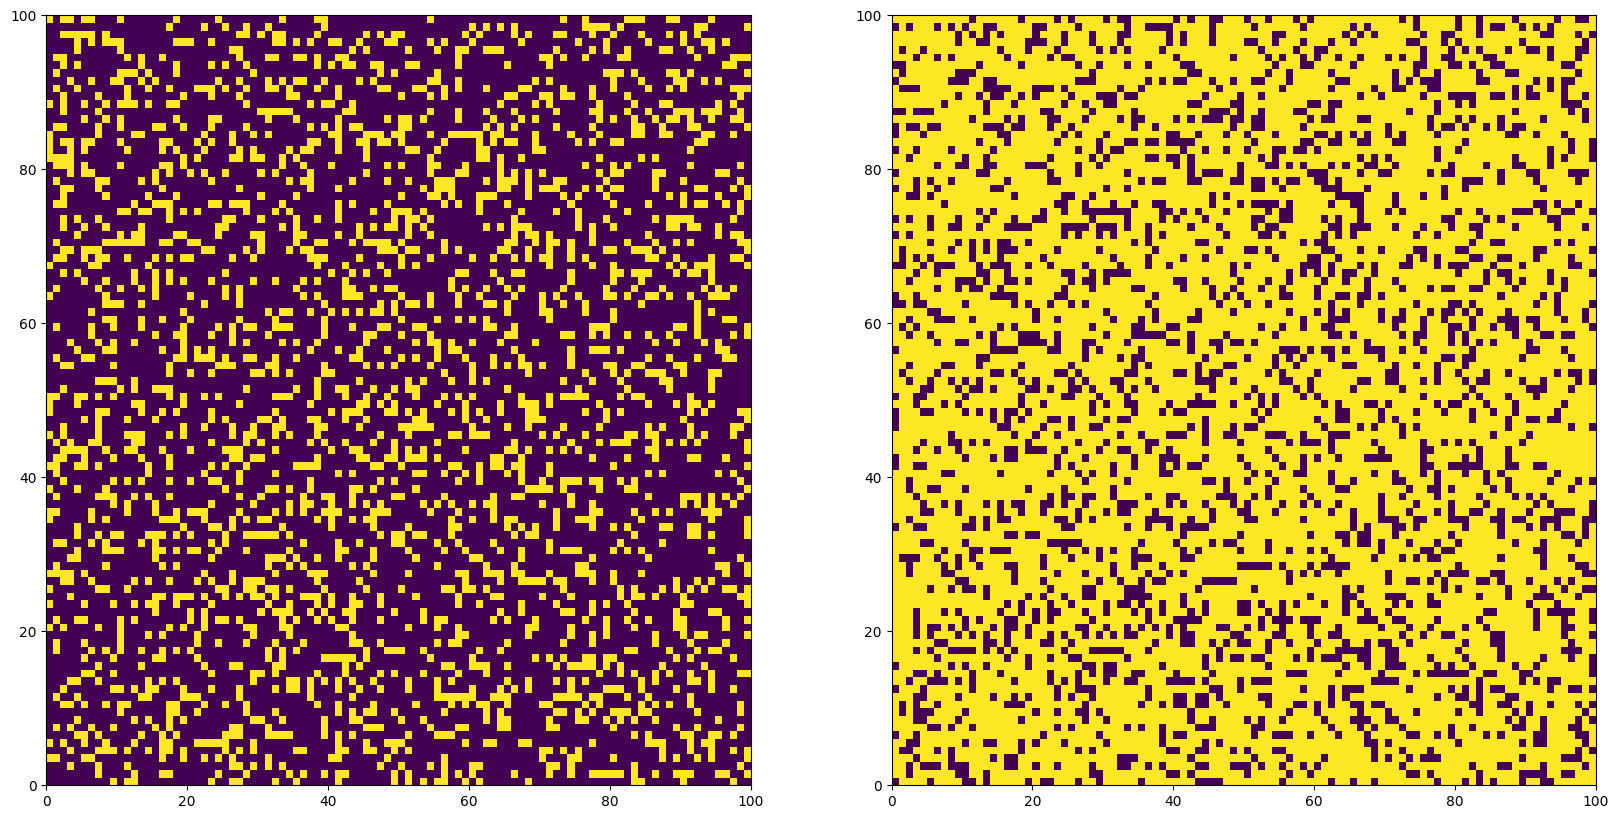

In [2]:
# Generamos el estado inicial de forma aleatoria
N = 100

# Creamos una matriz con números aleatorios
init_random = torch.rand((N,N)).to(device)
lattice_n = torch.zeros((N, N)).to(device)

# Para después crear una red con mayoría de spines positivos
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

# Y repetimos para otra con la mayoría de espines negativos
init_random = torch.rand((N,N)).to(device)
lattice_p = torch.zeros((N, N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

# Unimos las dos redes para simular las dos a la vez
lattices = torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.pcolormesh(lattice_n.cpu())
plt.subplot(1,2,2)
plt.pcolormesh(lattice_p.cpu())
plt.show()

# Definimos la energía:

$$
E = -J\sum_{<i,j>}S_iS_j- H\sum_i s_i
$$


In [3]:
# Definimos la energía del sistema
def get_energy_arr(lattices, h=0.0):
    # Usamos un kernel para aplicar la interacción con los vecinos más cercanos
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattices * conv2d(lattices, kern, padding='same')
    # sumamos el efecto del campo magnético
    arr += -h*lattices
    return arr

def get_energy(lattices):
    # Sumamos las energías para obtener la energía de la red
    return get_energy_arr(lattices).sum(axis=(1,2,3))

def get_dE_arr(lattices, h=0.0):
    return -2*get_energy_arr(lattices, h)

In [4]:
# Definimos el algoritmo de metrópolis
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    # Cambiamos la forma de BJs para que sea compatible con la de spin_tensor_batch
    BJs = BJs.reshape([-1,1,1,1])
    for t in range(times):
        # Elegimos un subconjunto de la red
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        # Calculamos el cambio en la energía
        # los índices i::2 y j::2 son para seleccionar los subconjuntos de la red
        # posiciones pares o impares en x y en y)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2]
        # Decidimos si aceptamos el cambio
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        # Cambiamos los spines que cumplen la condición
        spin_tensor_batch[:,:,i::2,j::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3))/N**2)
    return torch.vstack(avg_spins), torch.vstack(energies)


In [ ]:
# Resolvemos para obtener los spines y la energía.
BJs = 0.5*torch.ones(lattices.shape[0]).to(device) # Generamos un tensor con el valor de beta*J
# hemos puesto generado tandos como tensores para poder simular varias redes a la vez
spins, energies = metropolis(lattices, 1000, BJs)

$$
\bar{m} = <s>
$$

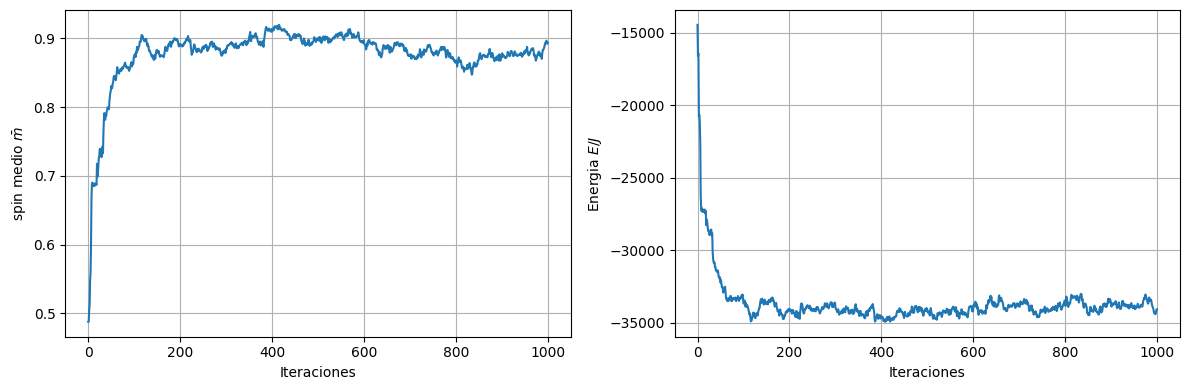

In [ ]:
# Representamos La media del spin en cada iteración
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins[:,1].cpu())
ax.set_xlabel('Iteraciones')
ax.set_ylabel(r'spin medio $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies[:,1].cpu())
ax.set_xlabel('Iteraciones')
ax.set_ylabel(r'Energia $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

In [5]:
# Ahora vamos a obtener la magnetización y la energía en función de la temperatura
# Tomando m como función de la temperatura T = 1/kB = J/(BJ)k

def get_spin_energy(lattice, BJs):
    # Generamos tantas copias de la red como valores de BJs para simularlas a la vez
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1)
    # Resolvemos el sistema
    spins, energies = metropolis(lattices, 1000, BJs)
    # Calculamos la media y la desviación estándar de los spines y la energía
    # para obtener la magnetización, la energía y el calor específico
    spins_avg = torch.mean(spins[-400:], axis=0)
    spins_std = torch.std(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, spins_std, energies_avg, energies_std



In [ ]:
BJs2 = 1/torch.linspace(1, 3, 50).to(device)
spins_avg_n2, spins_std, E_means_n2, E_stds_n2 = get_spin_energy(lattice_n, BJs2)
spins_avg_p2, spins_std, E_means_p2, E_stds_p2 = get_spin_energy(lattice_p, BJs2)


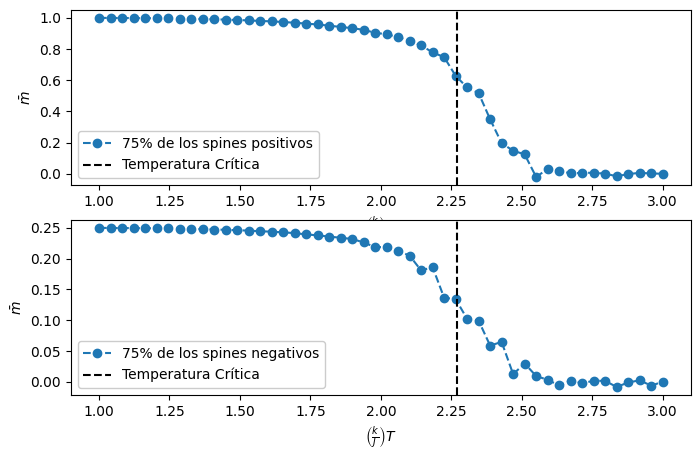

In [ ]:
# Representamos los resultados
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(1/BJs2.cpu(), spins_avg_n2.cpu(), 'o--', label='75% de los spines positivos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2,1,2)
plt.plot(1/BJs2.cpu(), spins_avg_p2.cpu(), 'o--', label='75% de los spines negativos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

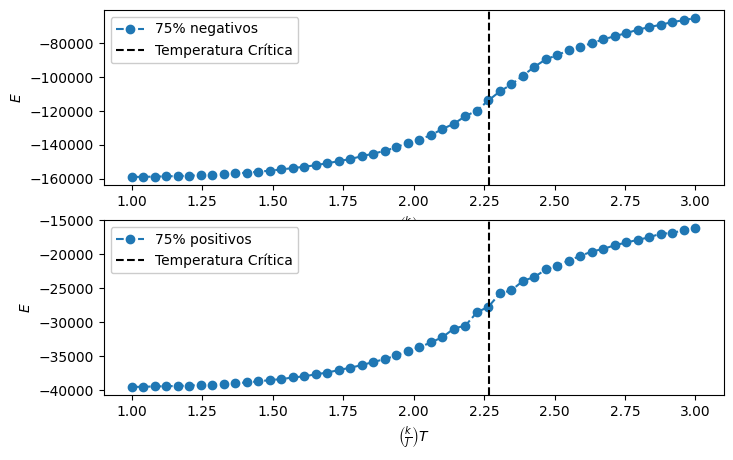

In [ ]:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(1/BJs2.cpu(), E_means_n2.cpu(), 'o--', label='75% negativos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$E$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2,1,2)
plt.plot(1/BJs2.cpu(), E_means_p2.cpu(), 'o--', label='75% positivos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$E$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

$$
C_v = \frac{(<E(s)^2>-<E(s)>^2)}{TN}
$$

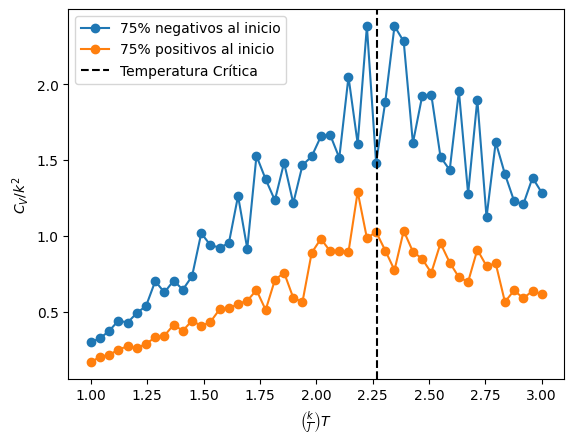

In [ ]:
plt.plot(1/BJs2.cpu(), E_stds_n2.cpu()*BJs2.cpu()/N, '-o',label='75% negativos al inicio')
plt.plot(1/BJs2.cpu(), E_stds_p2.cpu()*BJs2.cpu()/N, '-o', label='75% positivos al inicio')
plt.axvline(2.27, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

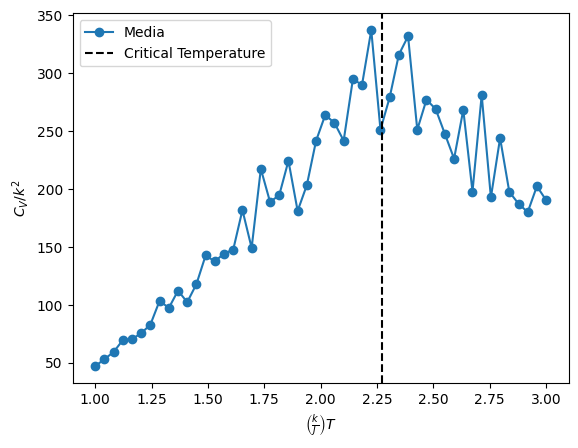

In [ ]:

plt.plot(1/BJs2.cpu(), (E_stds_n2.cpu()*BJs2.cpu() + E_stds_p2.cpu()*BJs2.cpu())/2, '-o', label='Media')
plt.axvline(2.27, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

$$
\tau = \frac{T-T_c}{T}
$$

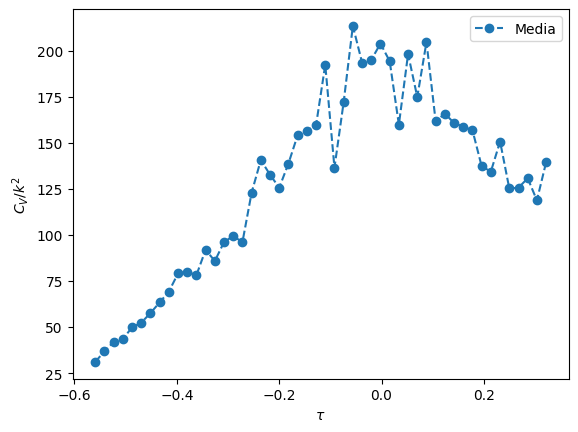

In [ ]:
tau = (1/BJs2.cpu()-2.27)/2.27

plt.plot(tau, (E_stds_n2.cpu()*BJs2.cpu() + E_stds_p2.cpu()*BJs2.cpu())/2, '--o', label='Media')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()

# Repetimos la simulación 2D para varios tamaños de la red

In [7]:
import pandas as pd
from time import time

In [8]:

def lattices2D(N):
  init_random = torch.rand((N,N)).to(device)
  lattice_n = torch.zeros((N, N)).to(device)
  lattice_n[init_random>=0.75] = 1
  lattice_n[init_random<0.75] = -1
  init_random = torch.rand((N,N)).to(device)
  lattice_p = torch.zeros((N, N)).to(device)
  lattice_p[init_random>=0.25] = 1
  lattice_p[init_random<0.25] = -1

  return lattice_p

Ns = [50,75,100, 200]
times = []
data = pd.DataFrame() # Creamos un dataframe vacío para almacenar los resultados
BJs2 = 1/torch.linspace(1, 5, 30).to(device)
data['BJs'] = BJs2.cpu().numpy()
spins_avgs, spins_stds, E_meanss, E_stdss = [], [], [], []
for N in Ns:
  lattice_n = lattices2D(N)
  inicio = time()
  spins_avg, spins_std, E_means, E_stds_n = get_spin_energy(lattice_n, BJs2)
  print(f'N={N} tarda {time()-inicio} segundos')
  times.append(time()-inicio)
  data['spins_avg_N='+str(N)] = spins_avg.cpu().numpy()
  data['spins_std_N='+str(N)] = spins_std.cpu().numpy()
  data['E_means_N='+str(N)] = E_means.cpu().numpy()
  data['E_stds_N='+str(N)] = E_stds_n.cpu().numpy()
  spins_avgs.append(spins_avg)
  E_meanss.append(E_means)
  E_stdss.append(E_stds_n)
  spins_stds.append(spins_std)

data.to_csv('ising2D.csv', index=False)

N=50 tarda 1.8003759384155273 segundos
N=75 tarda 1.209031581878662 segundos
N=100 tarda 1.4457688331604004 segundos
N=200 tarda 3.6051857471466064 segundos


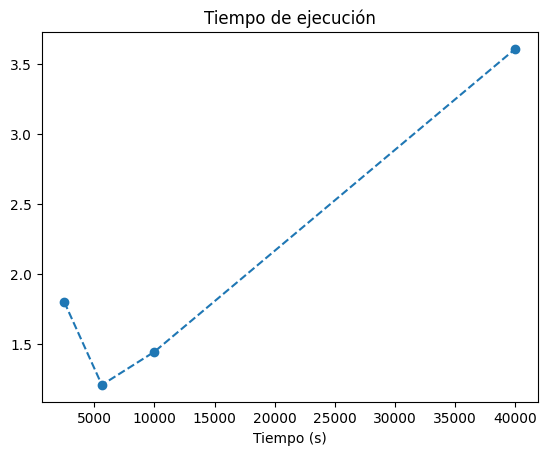

In [9]:
n = [N**2 for N in Ns]
plt.plot(n, times, 'o--')
# dibujamos una tendencia lineal para comparar
plt.xlabel('Tiempo (s)')
plt.ylabel('')
plt.title('Tiempo de ejecución')
plt.show()


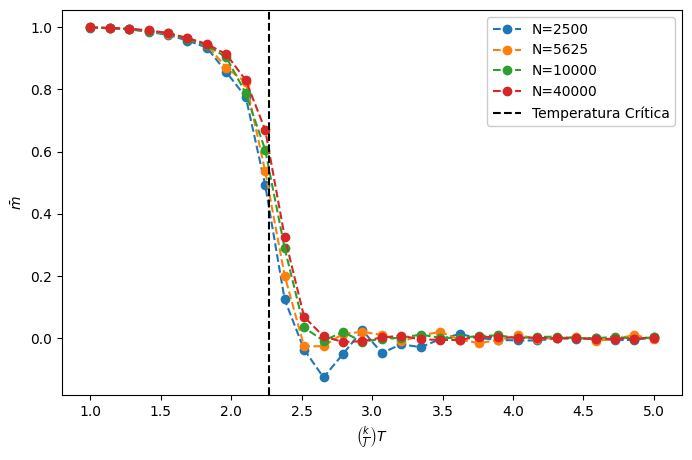

In [ ]:
plt.figure(figsize=(8,5))
for i, N in enumerate(Ns):
  plt.plot(1/BJs2.cpu(), spins_avgs[i].cpu(), 'o--', label=f'N={N**2}')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

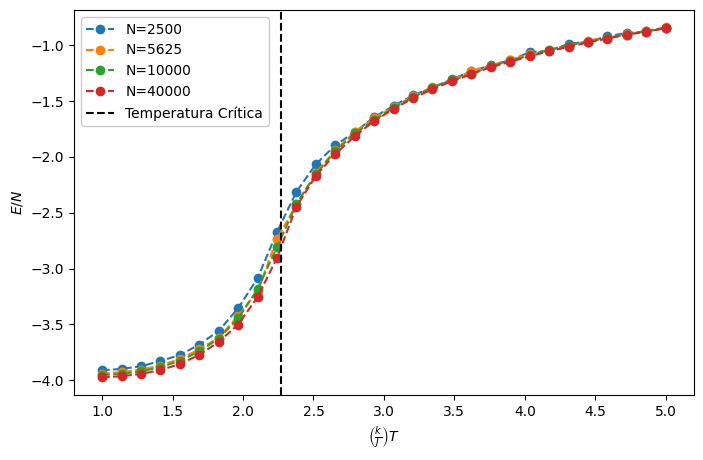

In [ ]:
plt.figure(figsize=(8,5))
for i, N in enumerate(Ns):
  plt.plot(1/BJs2.cpu(), E_meanss[i].cpu()/N**2, 'o--', label=f'N={N**2}')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$E/N$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

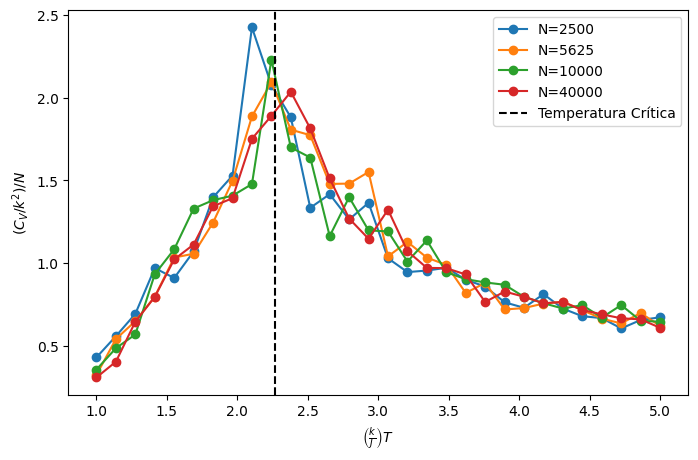

In [ ]:
plt.figure(figsize=(8,5))
for i, N in enumerate(Ns):
  plt.plot(1/BJs2.cpu(), E_stdss[i].cpu()*BJs2.cpu()/N, '-o',label=f'N={N**2}')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$(C_V / k^2)/N$')
plt.legend()
plt.show()

In [ ]:
tau = (1/BJs2.cpu()-2.27)/2.27

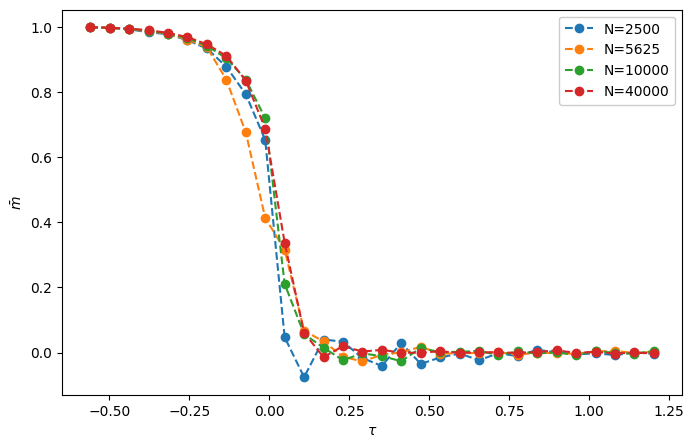

In [ ]:
plt.figure(figsize=(8,5))
for i, N in enumerate(Ns):
  plt.plot(tau, spins_avgs[i].cpu(), 'o--', label=f'N={N**2}')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

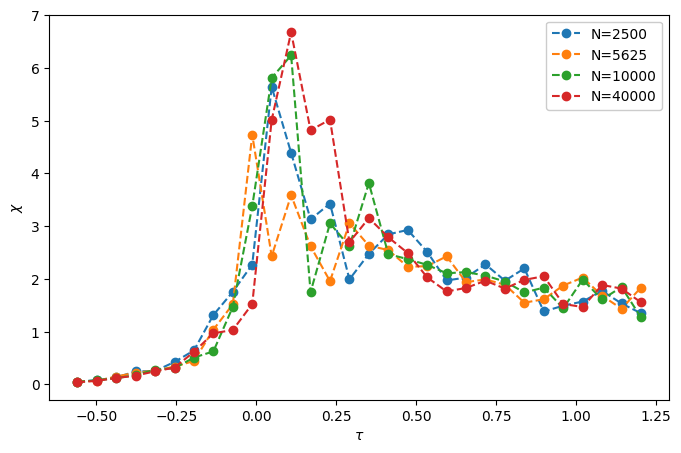

In [ ]:
plt.figure(figsize=(8,5))
for i, N in enumerate(Ns):
  plt.plot(tau, spins_stds[i].cpu()*N, 'o--', label=f'N={N**2}')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\chi$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [10]:
from IPython.display import clear_output

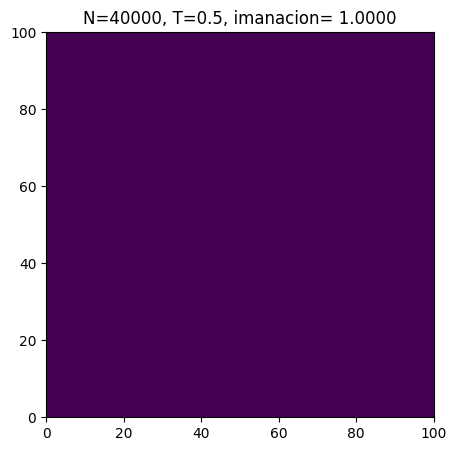

In [12]:
# Ahora quiero definir un metropolis igual que el anterior pero que me devuelva la red en cada paso



def plot_metropolis(lattice, BJ, h=0.0):
    if len(lattice.shape) == 2:
        lattice = lattice.unsqueeze(dim=0)
    spin_tensor_batch = lattice.repeat(1,1,1,1)
    BJs = BJ*torch.ones(lattice.shape[0]).to(device)
    lattices = []
    for t in range(1000):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch, h)[:,:,i::2,j::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2][change] *=-1
        lattices.append(spin_tensor_batch)
    return lattices

# quiero que plot_metropolis me devuelva la red con distintas temperaturas habiendo hecho 100 pasos




lattice_p = lattices2D(100)

lattices = plot_metropolis(lattice_p, 1)

for beta in np.linspace(1/2, 1/5, 20):
    clear_output(wait=True)
    lattices = plot_metropolis(lattices[-1], beta, h=0)

    plt.figure(figsize=(5,5))
    for i in range(10):
        plt.pcolormesh(lattices[i][0,0].cpu())

    plt.title(f'N=100, T={np.round(1/beta,4)}, imanacion= {lattices[-1].mean().item():.4f}')
    plt.show()

for beta in list(np.linspace(2, 1/5, 20))[::-1]:
    clear_output(wait=True)
    lattices = plot_metropolis(lattices[-1], beta, h=0)

    plt.figure(figsize=(5,5))
    for i in range(10):
        plt.pcolormesh(lattices[i][0,0].cpu())

    plt.title(f'N={200**2}, T={np.round(1/beta,4)}, imanacion= {lattices[-1].mean().item():.4f}')
    plt.show()

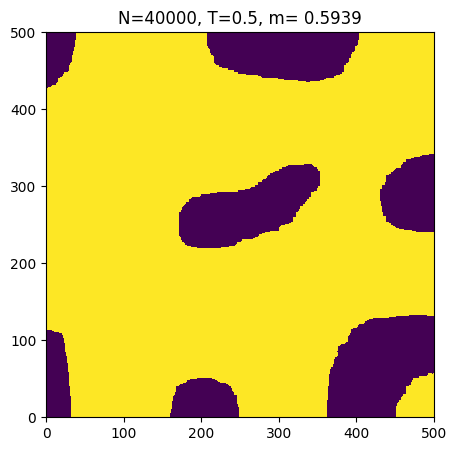

In [ ]:
# vamos a hacer una animación en mp4 con el código anterior
import matplotlib.animation as animation

lattice_p = lattices2D(500)

lattices = plot_metropolis(lattice_p, 1)

fig = plt.figure(figsize=(5,5))
ims = []

# primero calentamos la red, quiero que se vea el título en la animación
for beta in np.linspace(1/2, 1/5, 20):

    lattices = plot_metropolis(lattices[-1], beta, h=0)
    # para que se vea el título
    plt.title(f'N={200**2}, T={np.round(1/beta,4)}, m= {lattices[-1].mean().item():.4f}')
    im = plt.pcolormesh(lattices[-1][0,0].cpu())

    ims.append([im])
# ahora la enfrianos
for beta in list(np.linspace(2, 1/5, 20))[::-1]:
    lattices = plot_metropolis(lattices[-1], beta, h=0)
    plt.title(f'N={200**2}, T={np.round(1/beta,4)}, m= {lattices[-1].mean().item():.4f}')
    im = plt.pcolormesh(lattices[-1][0,0].cpu())
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

ani.save('ising500.gif', writer='pillow', fps=10)

